In [1]:
%matplotlib inline

import os

import cmocean
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import rasterio
from rasterio.plot import show

plt.style.use("ggplot")

# DSToolkit PostGIS integration: accessing commonly used spatial datasets

This notebook provides a brief illustration of how to access spatial data via the DSToolkit. This functionality is very new/experimental - **feedback appreciated**! More detailed tutorials will be made available when I have time... :-)

**Note:** If you're looking for data so you can make maps using conventional desktop GIS (e.g. ArcGIS or QGIS), please see also the notebook `create_gis_package.ipynb`, which creates a data package (`.zip` archive) for your area of interest.

## 1. Connect to database

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


## 2. Get fylke boundaries

List of layers is [here](https://github.com/NIVANorge/niva_jupyter_hub/blob/master/postgis_db/postgis_db_dataset_summary.md).

In [3]:
# Read fylker
fyl_gdf = nivapy.da.read_postgis("cultural", "norway_kartverket_fylker_2019_poly", eng)
fyl_gdf

,objtype,versjonid,fylkes_num,fylkes_navn,geom,id
0,Fylke,4.1,11,Rogaland,"MULTIPOLYGON (((-92079.54 6636303.79, -88921.1...",1
1,Fylke,4.1,19,Troms,"MULTIPOLYGON (((548801.23 7721399.97, 560944.0...",2
2,Fylke,4.1,15,Møre og Romsdal,"MULTIPOLYGON (((-20575.89 6963321.31, -19545.1...",3
3,Fylke,4.1,8,Telemark,"MULTIPOLYGON (((79802.24 6605143.1, 79806.9 66...",4
4,Fylke,4.1,7,Vestfold,"MULTIPOLYGON (((203038.57 6586598.8, 202867.35...",5
5,Fylke,4.1,1,Østfold,"MULTIPOLYGON (((248595.73 6586367.63, 249445.4...",6
6,Fylke,4.1,3,Oslo,"MULTIPOLYGON (((255493.65 6656227.71, 255286.5...",7
7,Fylke,4.1,5,Oppland,"MULTIPOLYGON (((134985.3 6829515.79, 136125.5 ...",8
8,Fylke,4.1,4,Hedmark,"MULTIPOLYGON (((270922.88 6828914.34, 270901.5...",9
9,Fylke,4.1,18,Nordland,"MULTIPOLYGON (((372929.38 7521632.83, 379075.1...",10


<Axes: >

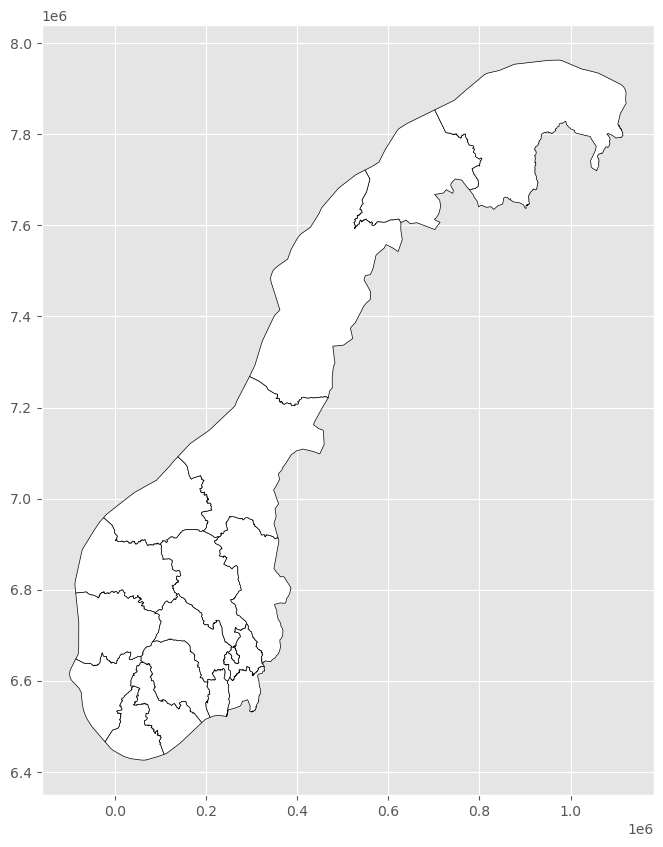

In [4]:
# Plot
fyl_gdf.plot(
    facecolor="white",
    edgecolor="black",
    figsize=(10, 10),
)

<Axes: >

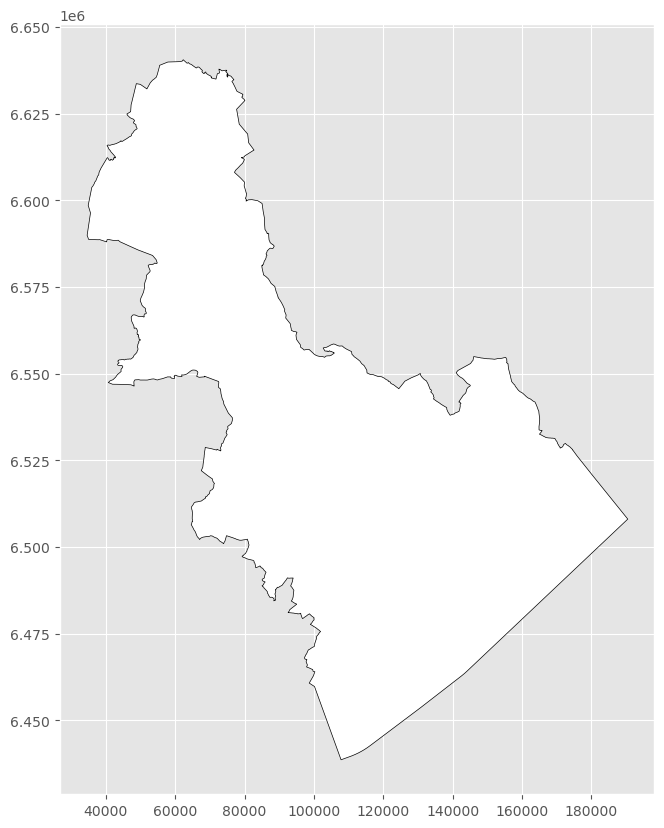

In [5]:
# Focus on Aust-Agder
clip_gdf = fyl_gdf.query("fylkes_num == 9")

# Plot
clip_gdf.plot(
    facecolor="white",
    edgecolor="black",
    figsize=(10, 10),
)

## 3. Extract CORINE land cover (2018)

In [6]:
# Read CORINE-2018 land cover, clipping to the specified fylke
gdf = nivapy.da.read_postgis(
    "physical",
    "norway_nibio_corine_2018_poly",
    eng,
    clip=clip_gdf,
)

gdf.head()

Converting to the projection of target dataset (EPSG:32633)


,klasse,kode,norsk,english,id,geom
0,5.1.2,512.0,Innsjø,Water bodies,1,"POLYGON ((48280.849 6474924.906, 48269.69 6474..."
1,3.1.3,313.0,Blandingsskog,Mixed forest,2,"POLYGON ((47948.939 6466425.509, 47922.177 646..."
2,3.1.3,313.0,Blandingsskog,Mixed forest,3,"POLYGON ((48761.355 6478328.789, 48752.431 647..."
3,2.4.3,243.0,Spredt jordbruksareal,"Land principally occupied by agriculture, with...",4,"POLYGON ((48168.856 6473953.693, 48138.528 647..."
4,3.1.1,311.0,Lauvskog,Broad-leaved forest,5,"POLYGON ((48282.279 6465087.433, 48255.513 646..."


<Axes: >

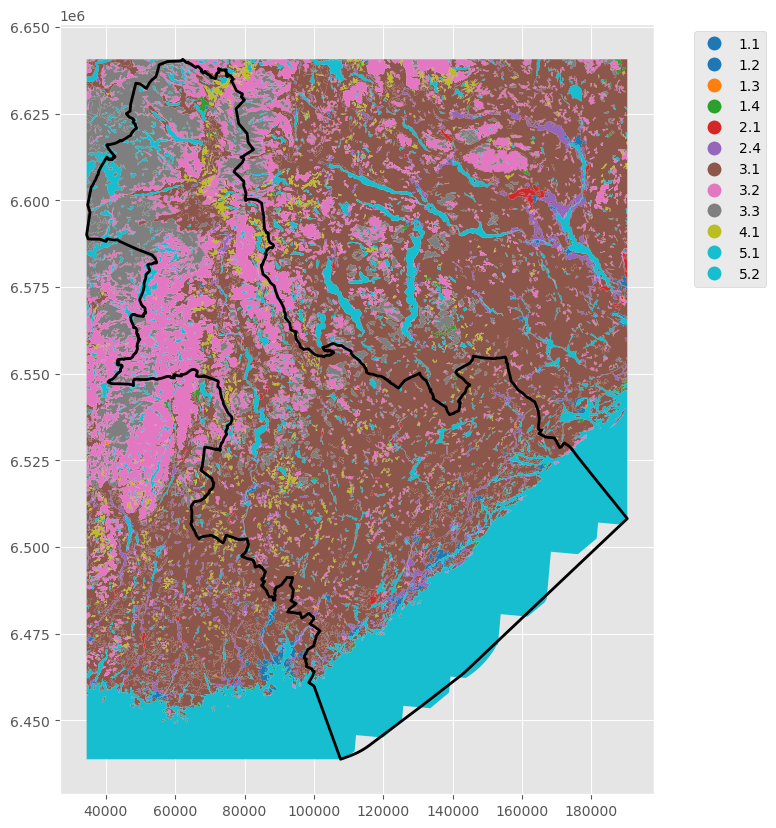

In [7]:
# Get top level class
gdf["main_class"] = gdf["klasse"].str[:3]

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

gdf.plot(
    column="main_class",
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.2, 1)},
    ax=ax,
)

clip_gdf.plot(edgecolor="k", facecolor="none", ax=ax, lw=2)

## 4. Extract 50 m DEM and hillshade

Converting to the projection of target dataset ({'proj': 'utm', 'zone': 33, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True})
Converting to the projection of target dataset ({'proj': 'utm', 'zone': 33, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True})


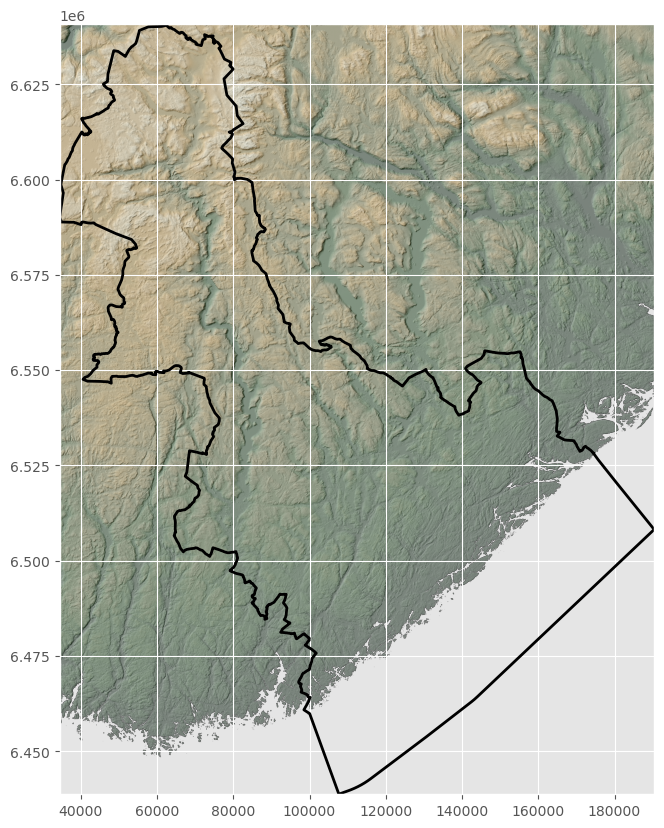

In [8]:
# Clip raster to fylke
ras_list = [
    r"/home/jovyan/shared/common/01_datasets/spatial/norway_kartverket_50m_dem.tif",
    r"/home/jovyan/shared/common/01_datasets/spatial/norway_kartverket_50m_hillshade.tif",
]

for ras_path in ras_list:
    out_gtiff = os.path.split(ras_path)[1]
    out_gtiff = os.path.join("../examples/raster", out_gtiff)

    nivapy.spatial.clip_raster_to_gdf(
        ras_path,
        out_gtiff,
        clip_gdf,
        bounding_box=True,
    )

# Plot clipped version
dem = rasterio.open("../examples/raster/norway_kartverket_50m_dem.tif")
hil = rasterio.open("../examples/raster/norway_kartverket_50m_hillshade.tif")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot
cmap = cmocean.tools.crop_by_percent(cmocean.cm.topo, 50, which="min", N=None)
show(dem, ax=ax, cmap=cmap)
show(hil, ax=ax, alpha=0.6, cmap="gray")

# Plot mask
clip_gdf.plot(edgecolor="k", facecolor="none", ax=ax, lw=2)

dem.close()
hil.close()